In [9]:
import os,glob
from astropy.io import fits
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

%matplotlib inline

# Overview

This notebook is a demo of how we can apply principal component analysis (PCA) to Kepler light curve data, and identify systematic trends that are not originated from the star.  

# Data Prep

This section prepares Kepler Q1 data for PCA analysis as follows:
- Remove timestamps where Kepler's quality flag (SAP_QUALITY) is not zero
- Scaling the flux so that with the mean of each light curve 
- Imputing the missing data (including flagged data) using interprolation
- Removing the last ~10% of the light curve due to large portion of missingness

In [10]:
fitslist=random.sample(glob.glob('Kepler_q1/*llc.fits'),1000)
#fitslist=glob.glob('Kepler_q1/*llc.fits')

In [11]:
def nan_prep(y):
    return np.isnan(y), lambda x: x.nonzero()[0]

for i,file in enumerate(fitslist):
    hdu=fits.open(file)
    _time = np.array(hdu[1].data['TIME'])
    _flux = np.array(hdu[1].data['SAP_FLUX'])
    _qa = np.array(hdu[1].data['SAP_QUALITY'])
    _flux[_qa>0] = np.nan
    
    _flux = _flux/np.nanmean(_flux) #scaling the lightcurve
    nans,x= nan_prep(_flux)
    _flux[nans]= np.interp(x(nans), x(~nans), _flux[~nans]) #impute nans with interprolation
    
    _pdcflux = np.array(hdu[1].data['PDCSAP_FLUX'])
    _pdcflux = _pdcflux/np.nanmean(_pdcflux) #scaling the lightcurve
    nans,x= nan_prep(_pdcflux)
    _pdcflux[nans]= np.interp(x(nans), x(~nans), _pdcflux[~nans]) #impute nans with interprolation
    
    if i == 0:
        arr_time = _time.reshape((1639, 1))
        arr_flux = _flux.reshape((1639, 1))
        arr_pdcflux = _pdcflux.reshape((1639, 1))
    else:
        arr_time = np.concatenate((arr_time,_time.reshape((1639, 1))),axis=1)
        arr_flux = np.concatenate((arr_flux,_flux.reshape((1639, 1))),axis=1)
        arr_pdcflux = np.concatenate((arr_pdcflux,_pdcflux.reshape((1639, 1))),axis=1)

arr_time = arr_time[0:1500,:]
arr_flux = arr_flux[0:1500,:]
arr_pdcflux = arr_pdcflux[0:1500,:]

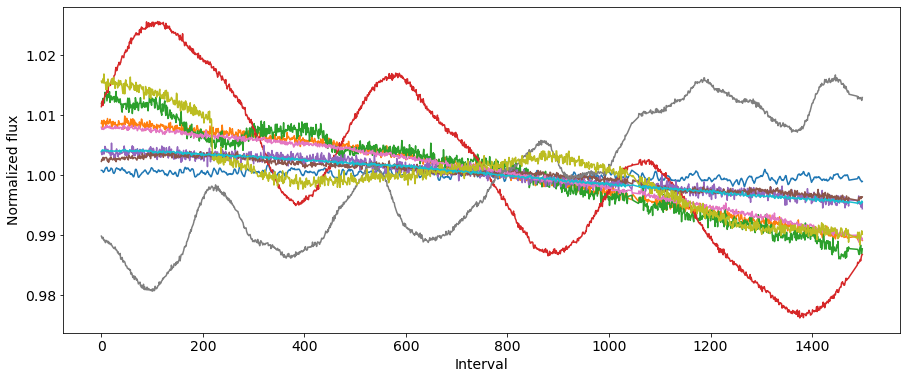

In [15]:
# Plot a random set of 5 light curves

plt.rc('font', size=14)
plt.figure(figsize=(15,6))
plt.xlabel('Interval')
plt.ylabel('Normalized flux')
for i in random.sample(range(len(fitslist)),10):
    plt.plot(arr_flux[0:,i])

# PCA analysis


In [16]:
# Decompose light curves into 50 components

n_com = 50
pca = PCA(n_components=n_com,svd_solver='full')
pca_trans = pca.fit_transform(arr_flux)

Explained variance ratio of the first 10 components =  [0.66326344 0.10714429 0.07199246 0.04808363 0.02606243 0.01756744
 0.00849097 0.00766259 0.00508448 0.0046887 ]


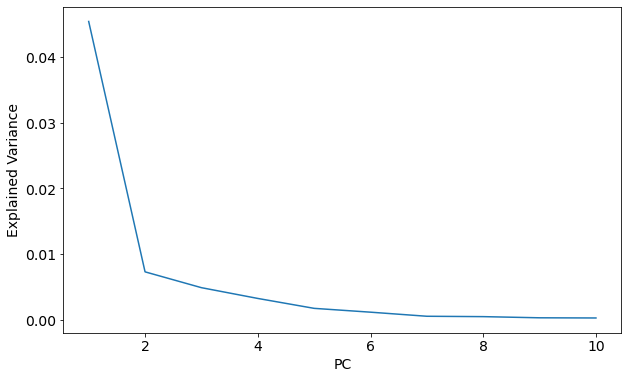

In [25]:
# Plot the explained variance from the first 10 components

plt.rc('font', size=14)
plt.figure(figsize=(10,6))
plt.xlabel('PC')
plt.ylabel('Explained Variance')
plt.plot(range(10)+np.ones(10),pca.explained_variance_[0:10])
print("Explained variance ratio of the first 10 components = ", pca.explained_variance_ratio_[0:10])

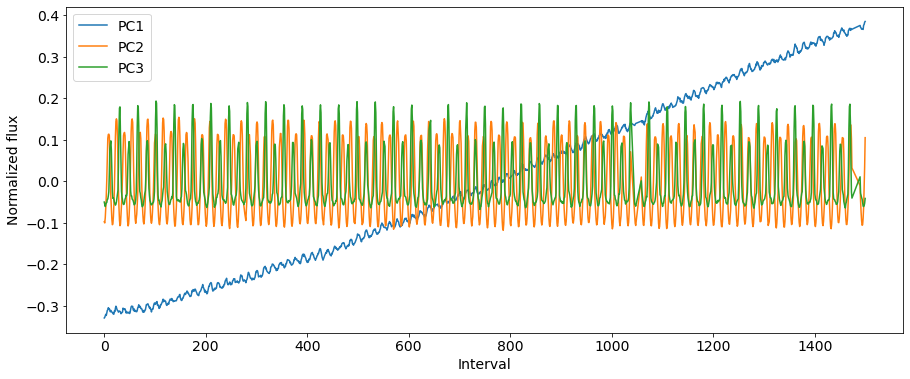

In [29]:
# Plot the first three pricipal components

plt.rc('font', size=14)
plt.figure(figsize=(15,6))
plt.xlabel('Interval')
plt.ylabel('Normalized flux')
legend = ['PC1','PC2','PC3']
for i in range(3):
    plt.plot(pca_trans[0:,i])
plt.legend(legend)

In [30]:
# Reconstruct light curves with pricipal components

flux_rct_all=np.dot(pca_trans,pca.components_)+pca.mean_

pcacom_cp = pca.components_
pcacom_cp[0,:]=0
flux_rct_nopc1=np.dot(pca_trans,pcacom_cp)+pca.mean_

In [40]:
#Select a light curve
ind=100

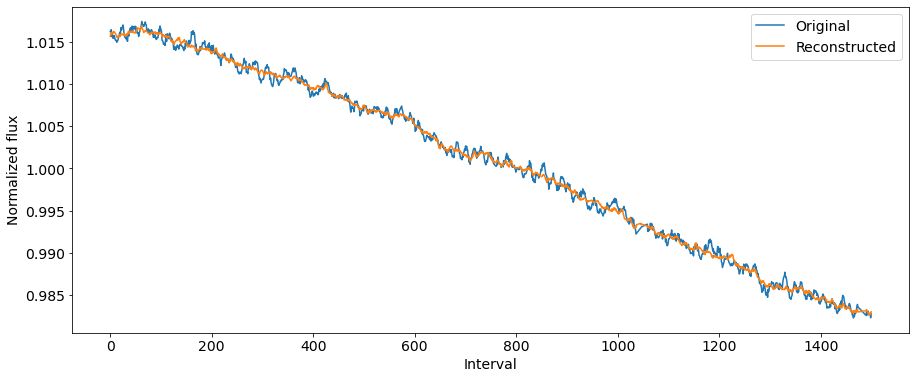

In [41]:
# Comparing the original light curve and the reconstructed light curve

plt.rc('font', size=14)
plt.figure(figsize=(15,6))
plt.xlabel('Interval')
plt.ylabel('Normalized flux')
legend = ['Original','Reconstructed']
plt.plot(arr_flux[:,ind])
plt.plot(flux_rct_all[:,ind])
plt.legend(legend)

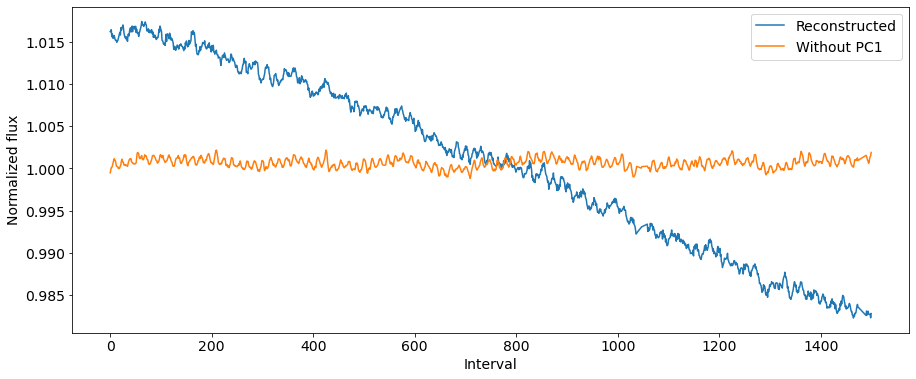

In [42]:
# Comparing the original light curve and the reconstructed light curve (without PC1)

plt.rc('font', size=14)
plt.figure(figsize=(15,6))
plt.xlabel('Interval')
plt.ylabel('Normalized flux')
legend = ['Reconstructed','Without PC1']
plt.plot(arr_flux[:,ind])
plt.plot(flux_rct_nopc1[:,ind])
plt.legend(legend)

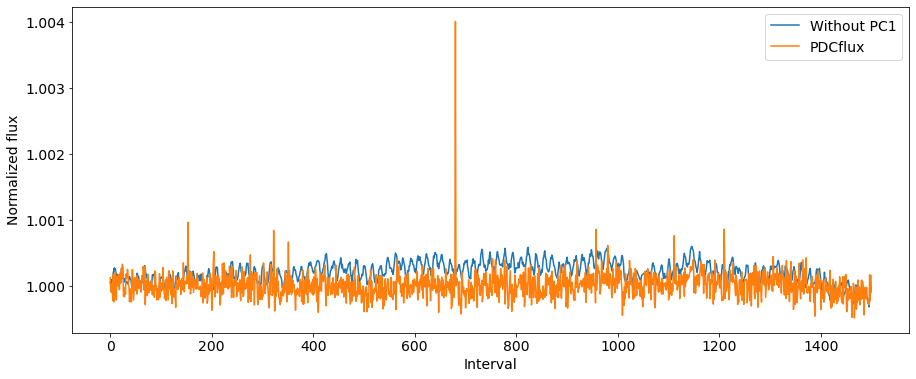

In [35]:
# Comparing the reconstructed light curve (without PC1) and PDCflux light curve

plt.rc('font', size=14)
plt.figure(figsize=(15,6))
plt.xlabel('Interval')
plt.ylabel('Normalized flux')
legend = ['Without PC1','PDCflux']
plt.plot(flux_rct_nopc1[:,ind])
plt.plot(arr_pdcflux[:,ind])
plt.legend(legend)